In [91]:
#Let's start by importing the proper packages
import math
import pandas as pd
import numpy as np
from operator import itemgetter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split #package to split data into testing and training sets
import sklearn.metrics as metrics


from sklearn import tree #package for decision tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor #package for random forest decision tree
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor #package for gradient boosting decision tree
from sklearn.ensemble import GradientBoostingClassifier 

In [92]:
sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
#let's read the data
INFILE = r"C:\Users\jaysa\OneDrive\Desktop\Practical Machine Learning\Assignment 2 Files\HMEQ_Loss.csv"

TARGET_B = "TARGET_BAD_FLAG" #Shortens variables for simplicity
TARGET_L = "TARGET_LOSS_AMT" 


df = pd.read_csv( INFILE )

dt = df.dtypes
dt

TARGET_BAD_FLAG      int64
TARGET_LOSS_AMT    float64
LOAN                 int64
MORTDUE            float64
VALUE              float64
REASON              object
JOB                 object
YOJ                float64
DEROG              float64
DELINQ             float64
CLAGE              float64
NINQ               float64
CLNO               float64
DEBTINC            float64
dtype: object

In [93]:
#Let's clean the data up a bit, first splitting variables into either an objList or numList
objList = []
numList = []
for i in dt.index :
    if i in ( [ TARGET_B, TARGET_L ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )
    if dt[i] in (["float64","int64"]) : numList.append( i )

#Let's take these categorical variables and impute some stuff. These NaN values are annoying. Fortunately, there is already
#an 'Other' category for jobs so we can add the NaN values to that category. Looking at the reason for loan, since the 
#majority of loans are for debt consolidation, we can safely assume the majority of NaN values are as well.

dt = df.dtypes
objList = []
for i in dt.index :
    if i in ( [ TARGET_B, TARGET_L ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )
        
for i in objList :
    print( i )
    print( df[i].unique() )
    g = df.groupby( i )
    print( g[i].count() )
    print( "MOST COMMON = ", df[i].mode()[0] )   
    print( "MISSING = ", df[i].isna().sum() )
    print( "\n\n")
    
for i in objList :
    if df[i].isna().sum() == 0 : continue
    print( i ) 
    print("HAS MISSING")
    NAME = "IMP_"+i
    print( NAME ) 
    df[NAME] = df[i]
    df[NAME] = df[NAME].fillna(df[NAME].mode()[0] )
    print( "variable",i," has this many missing", df[i].isna().sum() )
    print( "variable",NAME," has this many missing", df[NAME].isna().sum() )
    g = df.groupby( NAME )
    print( g[NAME].count() )
    print( "\n\n")
    df = df.drop( i, axis=1 )

REASON
['HomeImp' nan 'DebtCon']
REASON
DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64
MOST COMMON =  DebtCon
MISSING =  252



JOB
['Other' nan 'Office' 'Sales' 'Mgr' 'ProfExe' 'Self']
JOB
Mgr         767
Office      948
Other      2388
ProfExe    1276
Sales       109
Self        193
Name: JOB, dtype: int64
MOST COMMON =  Other
MISSING =  279



REASON
HAS MISSING
IMP_REASON
variable REASON  has this many missing 252
variable IMP_REASON  has this many missing 0
IMP_REASON
DebtCon    4180
HomeImp    1780
Name: IMP_REASON, dtype: int64



JOB
HAS MISSING
IMP_JOB
variable JOB  has this many missing 279
variable IMP_JOB  has this many missing 0
IMP_JOB
Mgr         767
Office      948
Other      2667
ProfExe    1276
Sales       109
Self        193
Name: IMP_JOB, dtype: int64





In [94]:
#Now our imputed reason and imputed job variables have no missing values. Let's rank the job tiers as a kind of corporate 
#ladder and create associated flag variables for each. In this ladder, the ProfExe is on top, followed by the Mgr, then
#Office, next Sales, Self, and finally Other.

print( df["IMP_JOB"].unique() )

df["y_IMP_JOB_6"] = (df.IMP_JOB.isin( ["ProfExe"] ) + 0 )
df["y_IMP_JOB_5"] = (df.IMP_JOB.isin( ["ProfExe","Mgr"] ) + 0)
df["y_IMP_JOB_4"] = (df.IMP_JOB.isin( ["ProfExe","Mgr","Office"] ) + 0)
df["y_IMP_JOB_3"] = (df.IMP_JOB.isin( ["ProfExe","Mgr","Office","Sales"] ) + 0)
df["y_IMP_JOB_2"] = (df.IMP_JOB.isin( ["ProfExe","Mgr","Office","Sales","Self"] ) + 0)
df["y_IMP_JOB_1"] = (df.IMP_JOB.isin( ["ProfExe","Mgr","Office","Sales","Self","Other"] ) + 0)
df = df.drop( "IMP_JOB", axis=1 )


#We also need to rank the reasons for the HMEQ. Since we found home improvement has a lower default rate the debt
#consolidation previously, we will assign home improvement the higher rank. We need to do this for both ObjList variables
#to build our decision tree model

print( df["IMP_REASON"].unique() )

df["y_IMP_REASON_2"] = (df.IMP_REASON.isin( ["HomeImp"] ) + 0 )
df["y_IMP_REASON_1"] = (df.IMP_REASON.isin( ["HomeImp","DebtCon"] ) + 0)
df = df.drop( "IMP_REASON", axis=1 )

print( df.head().T )

['Other' 'Office' 'Sales' 'Mgr' 'ProfExe' 'Self']
['HomeImp' 'DebtCon']
                            0             1             2       3  \
TARGET_BAD_FLAG      1.000000      1.000000      1.000000     1.0   
TARGET_LOSS_AMT    641.000000   1109.000000    767.000000  1425.0   
LOAN              1100.000000   1300.000000   1500.000000  1500.0   
MORTDUE          25860.000000  70053.000000  13500.000000     NaN   
VALUE            39025.000000  68400.000000  16700.000000     NaN   
YOJ                 10.500000      7.000000      4.000000     NaN   
DEROG                0.000000      0.000000      0.000000     NaN   
DELINQ               0.000000      2.000000      0.000000     NaN   
CLAGE               94.366667    121.833333    149.466667     NaN   
NINQ                 1.000000      0.000000      1.000000     NaN   
CLNO                 9.000000     14.000000     10.000000     NaN   
DEBTINC                   NaN           NaN           NaN     NaN   
y_IMP_JOB_6          0.000000  

In [95]:
#Let's verify that we have no more object type variables
dt = df.dtypes
objList = []
for i in dt.index :
    print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_B, TARGET_L ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )


for i in objList :
    thePrefix = "z_" + i
    y = pd.get_dummies( df[i], prefix=thePrefix, drop_first=True )   
    y = pd.get_dummies( df[i], prefix=thePrefix )   
    df = pd.concat( [df, y], axis=1 )
    df = df.drop( i, axis=1 )

 here is i ..... TARGET_BAD_FLAG  ..... and here is the type int64
 here is i ..... TARGET_LOSS_AMT  ..... and here is the type float64
 here is i ..... LOAN  ..... and here is the type int64
 here is i ..... MORTDUE  ..... and here is the type float64
 here is i ..... VALUE  ..... and here is the type float64
 here is i ..... YOJ  ..... and here is the type float64
 here is i ..... DEROG  ..... and here is the type float64
 here is i ..... DELINQ  ..... and here is the type float64
 here is i ..... CLAGE  ..... and here is the type float64
 here is i ..... NINQ  ..... and here is the type float64
 here is i ..... CLNO  ..... and here is the type float64
 here is i ..... DEBTINC  ..... and here is the type float64
 here is i ..... y_IMP_JOB_6  ..... and here is the type int32
 here is i ..... y_IMP_JOB_5  ..... and here is the type int32
 here is i ..... y_IMP_JOB_4  ..... and here is the type int32
 here is i ..... y_IMP_JOB_3  ..... and here is the type int32
 here is i ..... y_IMP_J

In [96]:
#Groovy! No more object variables. We need to remove missing values for numList variables, too. Here, we will apply 
#the median value of the appropriate category for simplicity
for i in numList :
    if df[i].isna().sum() == 0 : continue
    FLAG = "M_" + i
    IMP = "IMP_" + i
    print(i)
    print( df[i].isna().sum() )
    print( FLAG )
    print( IMP )
    print(" ------- ")
    df[ FLAG ] = df[i].isna() + 0
    df[ IMP ] = df[ i ]
    df.loc[ df[IMP].isna(), IMP ] = df[i].median()
    df = df.drop( i, axis=1 )

MORTDUE
518
M_MORTDUE
IMP_MORTDUE
 ------- 
VALUE
112
M_VALUE
IMP_VALUE
 ------- 
YOJ
515
M_YOJ
IMP_YOJ
 ------- 
DEROG
708
M_DEROG
IMP_DEROG
 ------- 
DELINQ
580
M_DELINQ
IMP_DELINQ
 ------- 
CLAGE
308
M_CLAGE
IMP_CLAGE
 ------- 
NINQ
510
M_NINQ
IMP_NINQ
 ------- 
CLNO
222
M_CLNO
IMP_CLNO
 ------- 
DEBTINC
1267
M_DEBTINC
IMP_DEBTINC
 ------- 


In [97]:
#Split the data

X = df.copy() #We are removing the target variables from X
X = X.drop( TARGET_B, axis=1 )
X = X.drop( TARGET_L, axis=1 )

Y = df[ [TARGET_B, TARGET_L] ] #And adding the target variables to Y

In [98]:
#This creates a training and testing data set where the train_size/test_size variables are the percentage of
#records assigned to each group. Here 80% go to the training group and 20% go to the testing group
#Assigning a random_state for the random number seed will produce repeatable split of test and training

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=3) 
print( "FLAG DATA" )
print( "TRAINING = ", X_train.shape ) # number of records assigned, number of variables 
print( "TEST = ", X_test.shape )

FLAG DATA
TRAINING =  (4768, 27)
TEST =  (1192, 27)


In [99]:
#The training data set has 4768 records and the test data set has 1192 records. Each set has 27 variables to consider
#Let's create the decision tree to determine the default probability of the loan

fm01_Tree = tree.DecisionTreeClassifier( max_depth=4 ) #The higher the depth, the better the model, but prone to overfitting
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_B ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of Default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_B], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_B], Y_Pred_test))

Probability of Default
Accuracy Train: 0.8951342281879194
Accuracy Test: 0.8758389261744967


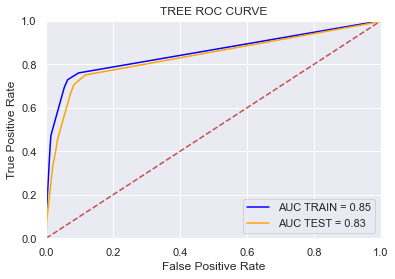

In [100]:
#Hey that's pretty good! Let's generate a ROC curve to make sure we're not overfitting and our True and False Positive Rates
#are where they should be

probs = fm01_Tree.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_B], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_Tree.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_B], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

fpr_tree = fpr_test
tpr_tree = tpr_test
auc_tree = roc_auc_test

plt.title('TREE ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train, color="blue")
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="orange")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


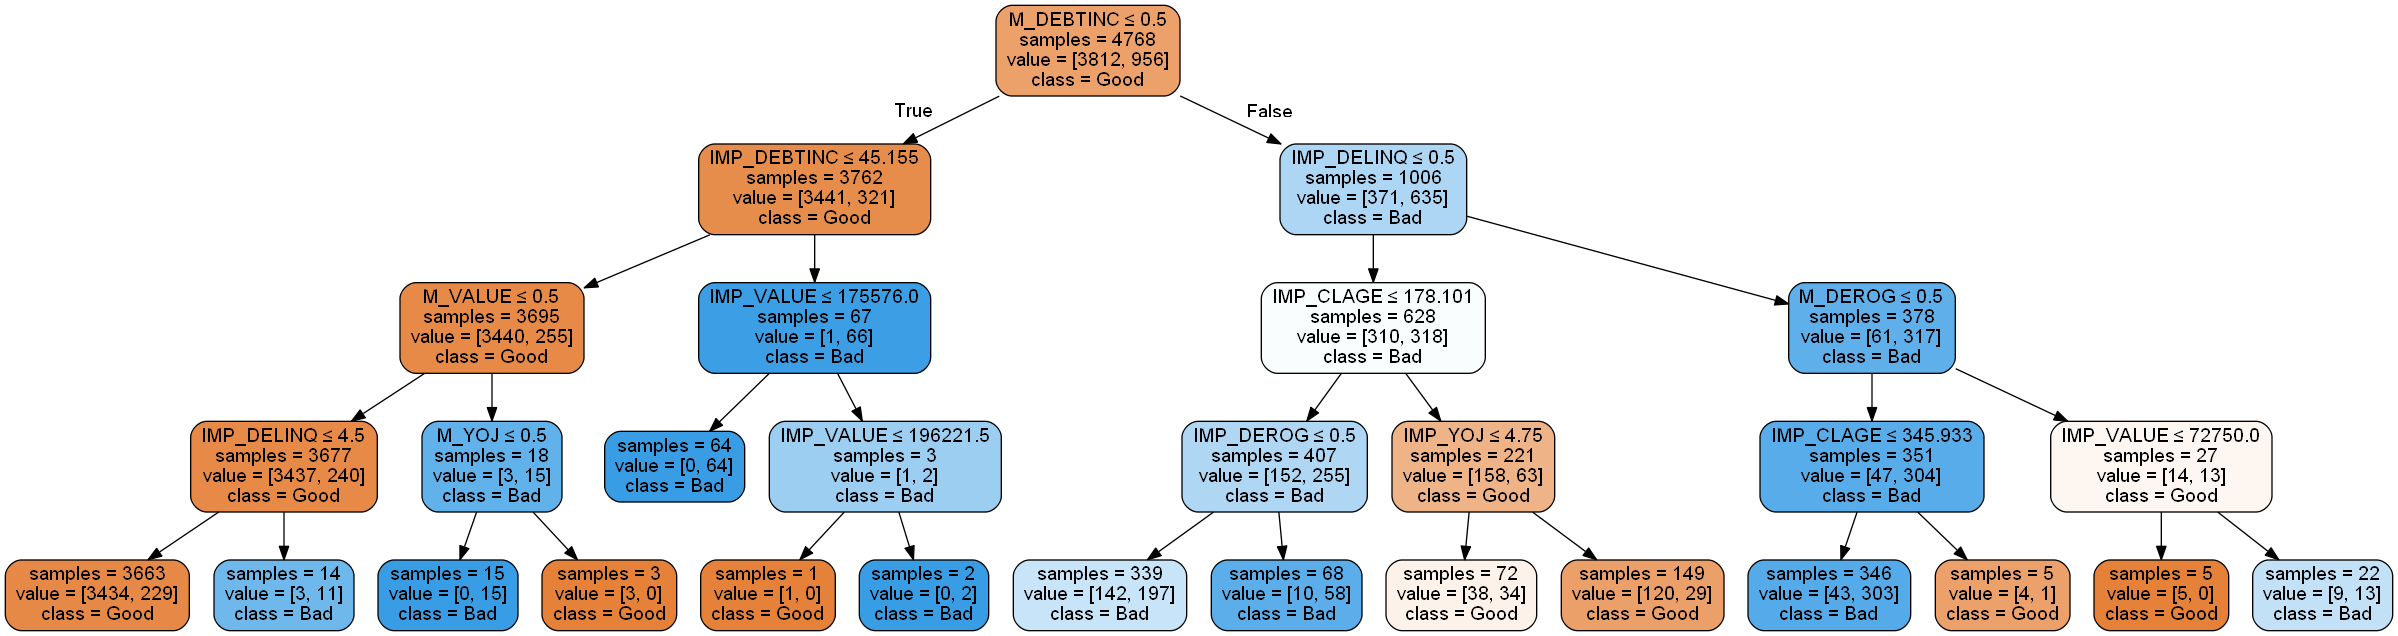

In [101]:
#Both training data and test data have similar values and don't show major signs of overfitting. Now we can show the
#decision tree. This section of code allows us to embed GraphViz files into our Jupyter notebook

import pydotplus
from sklearn import tree
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz

dot_data = StringIO()
tree.export_graphviz(fm01_Tree, out_file = dot_data,
    feature_names = X_train.columns.tolist(),
    filled = True, rounded = True,
    special_characters = True, class_names = ['Good','Bad'], impurity = False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [102]:
#This decision tree puts a lot of stock in the debt to income ratio of the person utilizing the HMEQ loan. This makes 
#intuitive sense. The more debt you have relative to your income, the likelier your chances of having a problem paying
#the debt back. Let's look at the other most important decision variables in this decision tree that predicts default.

def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

feature_cols = list( X.columns.values )
vars_tree_flag = getTreeVars( fm01_Tree, feature_cols ) 


for i in vars_tree_flag :
    print (i)

M_VALUE
IMP_VALUE
M_YOJ
IMP_YOJ
M_DEROG
IMP_DEROG
IMP_DELINQ
IMP_CLAGE
M_DEBTINC
IMP_DEBTINC


In [103]:
#This model shows that the value of the home, years on the job, derogatory credit marks, and delinquency 
#are other strong predictors of whether someone will default on a HMEQ loan

#Let's now separate out records of people who actually defaulted on a loan to predict the amount of loss 
#of the defaulted loans. We want to apply this to both training and test data

F = ~ Y_train[ TARGET_L ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_L ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

print( Z_train.describe() )
print( Z_test.describe() )

       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            956.0       956.000000
mean               1.0     13446.222803
std                0.0     10952.949148
min                1.0       320.000000
25%                1.0      5650.250000
50%                1.0     10982.000000
75%                1.0     17806.000000
max                1.0     78987.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            233.0       233.000000
mean               1.0     13284.733906
std                0.0     10382.590638
min                1.0       224.000000
25%                1.0      5639.000000
50%                1.0     11418.000000
75%                1.0     16495.000000
max                1.0     57268.000000


In [104]:
#We can see that the average loss on a defaulted loan is a little over $13,000 in both datasets. However, there are large
#outliers that may skew the decision tree. Let's deal with those outliers. The median loss is about $11,000 as is the
#standard deviation, so let's cap outlier amounts at $33,000

F = Z_train[ TARGET_L ] > 33000
Z_train.loc[ F, TARGET_L ] = 33000

F = Z_test[ TARGET_L ] > 33000
Z_test.loc[ F, [TARGET_L] ] = 33000

print( Z_train.describe() )
print( Z_test.describe() )

print( " ====== ")

print( "AMOUNT DATA" )
print( "TRAINING = ", W_train.shape )
print( "TEST = ", Z_test.shape )

       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            956.0       956.000000
mean               1.0     12781.328452
std                0.0      8893.296998
min                1.0       320.000000
25%                1.0      5650.250000
50%                1.0     10982.000000
75%                1.0     17806.000000
max                1.0     33000.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            233.0       233.000000
mean               1.0     12704.412017
std                0.0      8616.160282
min                1.0       224.000000
25%                1.0      5639.000000
50%                1.0     11418.000000
75%                1.0     16495.000000
max                1.0     33000.000000
AMOUNT DATA
TRAINING =  (956, 27)
TEST =  (233, 2)


In [105]:
#From these records of defaulted loans, we can look at the mean loss of both the training and testing data sets

amt_m01_Tree = tree.DecisionTreeRegressor( max_depth= 4 )
amt_m01_Tree = amt_m01_Tree.fit( W_train, Z_train[TARGET_L] )

Z_Pred_train = amt_m01_Tree.predict(W_train)
Z_Pred_test = amt_m01_Tree.predict(W_test)

print( "MEAN Train", Z_train[TARGET_L].mean() )
print( "MEAN Test", Z_test[TARGET_L].mean() )


MEAN Train 12781.328451882846
MEAN Test 12704.412017167382


In [106]:
#The training and testing data sets are fairly aligned predicting the mean loss. Let's also look at the Root Mean Squared
#Error and the most important variables for predicting the amount of loss in defaulted loans.

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_L], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_L], Z_Pred_test))

print("TREE RMSE Train:", RMSE_TRAIN )
print("TREE RMSE Test:", RMSE_TEST )

RMSE_TREE = RMSE_TEST

feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( amt_m01_Tree, feature_cols )

for i in vars_tree_amt :
    print(i)

TREE RMSE Train: 3564.307130322931
TREE RMSE Test: 4374.999394824516
LOAN
IMP_MORTDUE
IMP_DELINQ
IMP_CLNO
M_DEBTINC
IMP_DEBTINC


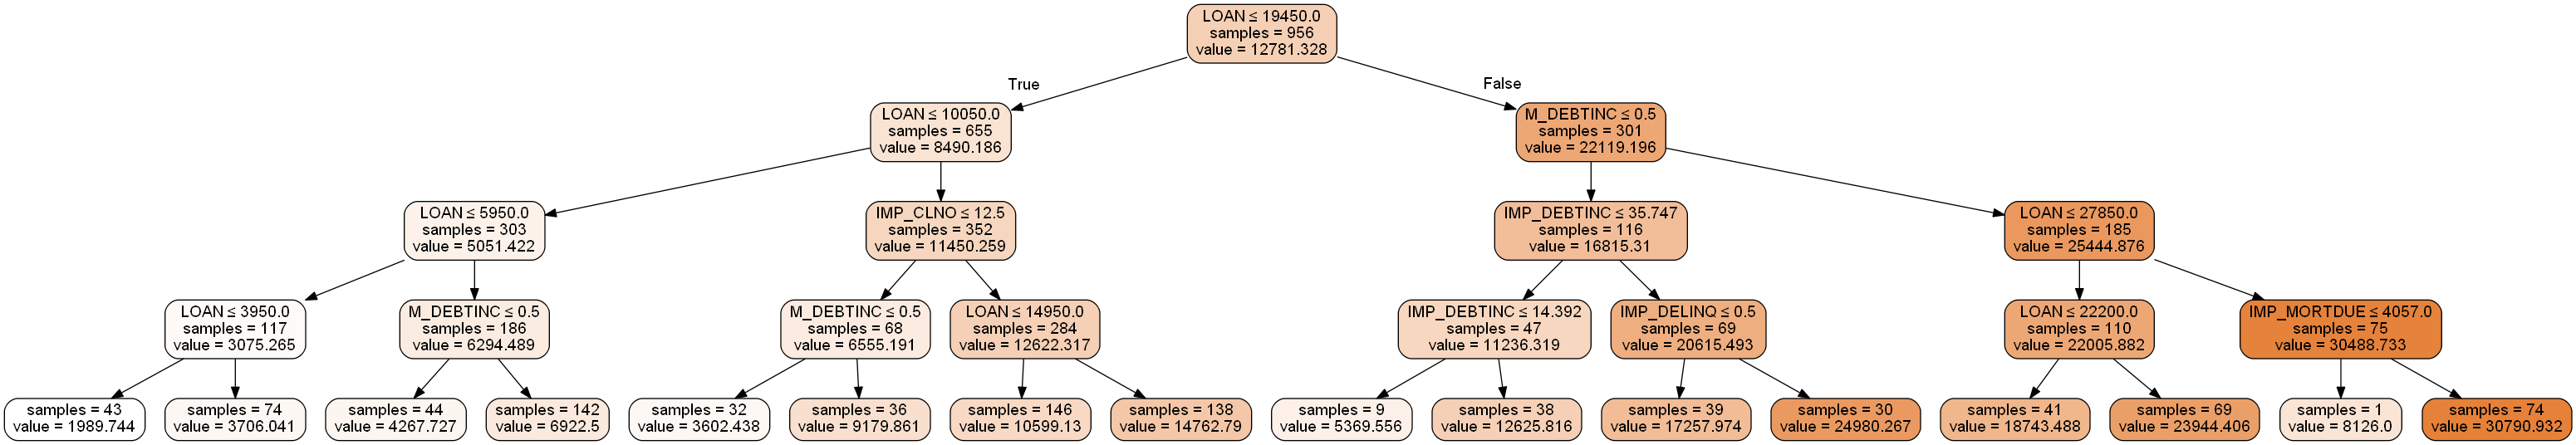

In [107]:
#The RMSE of the test data is higher than the training data, but not outrageously different. When predicting loan loss
#amount, the original loan amount is the greatest predictor. This also makes intuitive since as the higher the original
#amount of the loan, the higher the potential loss when someone defaults. Interestingly, debt to income ratio makes another
#appearance in being a predictor of how much a defaulted loan is predicted to lose.

#Now we can look at the decision tree for predicting loss amount for defaulted loans.
dot_data = StringIO()
tree.export_graphviz(amt_m01_Tree, out_file = dot_data,
    feature_names = X_train.columns.tolist(),
    filled = True, rounded = True,
    special_characters = True, class_names = ['Good','Bad'], impurity = False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [108]:
#The decision tree puts an enormous amount of stock in the original loan value and the debt to income ratio when 
#predicting the amount of loss of a defaulted loan. Perhaps a different model will react differently?

#Let's use a random forest model now to predict whether a loan will default.

fm01_RF = RandomForestClassifier( n_estimators = 50, random_state=2 )  #n_estimators is the number of trees/votes for a predictive outcome
fm01_RF = fm01_RF.fit( X_train, Y_train[ TARGET_B ] )

Y_Pred_train = fm01_RF.predict(X_train)
Y_Pred_test = fm01_RF.predict(X_test)

print("\n=============\n")
print("RANDOM FOREST\n")
print("Probability of default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_B], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_B], Y_Pred_test))
print("\n")



RANDOM FOREST

Probability of default
Accuracy Train: 0.9997902684563759
Accuracy Test: 0.8993288590604027




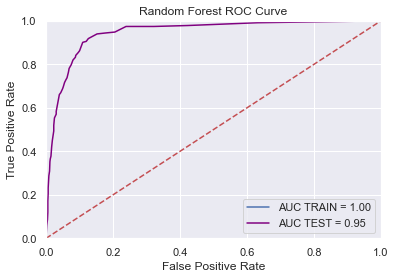

In [109]:
#We can see that the wisdom of the crowds... err... I mean wisdom of the trees in the forest becomes nearly flawless as
#the number of estimators increases. The test data is also more accurate than the standard decision tree.

#Onto the ROC curve!

probs = fm01_RF.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_B], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_RF.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_B], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

fpr_RF = fpr_test
tpr_RF = tpr_test
auc_RF = roc_auc_test

feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( fm01_RF, feature_cols )


plt.title('Random Forest ROC Curve')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="purple")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [110]:
#Well the training data is off the charts, but we do see the test data has a steep, but noticeable curve. Changing the
#random state or the number of estimators or seed state does not significantly alter the curve so let's keep it.

#Now let's take a look at which variables the random forest used most often in its estimators to predict whether a loan
#would default.

def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

for i in vars_RF_flag :
    print( i )

('M_DEBTINC', 100)
('IMP_DEBTINC', 71)
('IMP_CLAGE', 41)
('IMP_VALUE', 37)
('IMP_DELINQ', 37)
('LOAN', 34)
('IMP_CLNO', 31)
('IMP_MORTDUE', 31)
('IMP_YOJ', 25)
('IMP_DEROG', 21)


In [111]:
#Much like the decision tree, the random forest places enormous weight on the debt to income ratio. The random forest also
#thinks that the age of credit is a strong predictor of whether someone would default.

#Finally, let's look at how the random forest does when predicting loan loss amount of defaulted loans and which variables
#the random forest considers to be the most important.

amt_m01_RF = RandomForestRegressor(n_estimators = 50, random_state=8)
amt_m01_RF = amt_m01_RF.fit( W_train, Z_train[TARGET_L] )

Z_Pred_train = amt_m01_RF.predict(W_train)
Z_Pred_test = amt_m01_RF.predict(W_test)

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_L], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_L], Z_Pred_test))

print("RF RMSE Train:", RMSE_TRAIN )
print("RF RMSE Test:", RMSE_TEST )

RMSE_RF = RMSE_TEST

feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( amt_m01_RF, feature_cols )

for i in vars_RF_amt :
    print( i )

RF RMSE Train: 1040.8277492519935
RF RMSE Test: 2468.1956327670423
('LOAN', 100)
('IMP_CLNO', 11)
('IMP_DEBTINC', 8)
('M_DEBTINC', 8)


In [112]:
#The RMSE of both random forest sets are lower than the standard decision tree indicating a better predictive performance.
#Both models agree that the amount of the original loan and the debt to income ratio remain the biggest factors predicting
#loan loss amount for defaulted loans.

#Finally, let's use a gradiant boosting model and see how well it performs predicting defaults of loans.

fm01_GB = GradientBoostingClassifier( random_state=4 )
fm01_GB = fm01_GB.fit( X_train, Y_train[ TARGET_B ] )

Y_Pred_train = fm01_GB.predict(X_train)
Y_Pred_test = fm01_GB.predict(X_test)

print("\n=============\n")
print("GRADIENT BOOSTING\n")
print("Probability of default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_B], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_B], Y_Pred_test))
print("\n")



GRADIENT BOOSTING

Probability of default
Accuracy Train: 0.9234479865771812
Accuracy Test: 0.8909395973154363




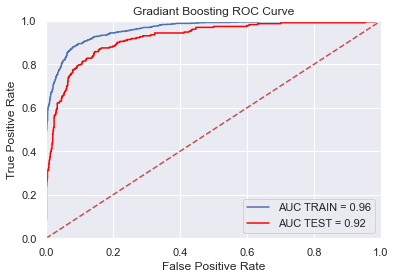

('M_DEBTINC', 100)
('IMP_DEBTINC', 29)
('IMP_DELINQ', 19)
('IMP_CLAGE', 13)


In [113]:
#Well the training data is not quite as accurate as the random forest, but gradiant boosting shows the highest accuracy 
#predicting the test data set.

#Let's look at the gradiant boosting ROC curve and the variables the gradiant boosting model thinks are most important.

probs = fm01_GB.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_B], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_GB.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_B], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

fpr_GB = fpr_test
tpr_GB = tpr_test
auc_GB = roc_auc_test


feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( fm01_GB, feature_cols )

plt.title('Gradiant Boosting ROC Curve')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

for i in vars_GB_flag :
    print(i)

In [114]:
#We can see the gradiant boosting ROC curve appears to be the most accurate while staying away from overfitting territory.
#All three models agree the debt to income ratio is the single biggest factor in predicting loan default.

#What does gradiant boosting say about predicting loss amount for defaulted loans and which variables are most important
#for making the prediction?

amt_m01_GB = GradientBoostingRegressor(random_state=1)
amt_m01_GB = amt_m01_GB.fit( W_train, Z_train[TARGET_L] )

Z_Pred_train = amt_m01_GB.predict(W_train)
Z_Pred_test = amt_m01_GB.predict(W_test)

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_L], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_L], Z_Pred_test))

print("GB RMSE Train:", RMSE_TRAIN )
print("GB RMSE Test:", RMSE_TEST )

RMSE_GB = RMSE_TEST

feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( amt_m01_GB, feature_cols )


for i in vars_GB_amt :
    print(i)

GB RMSE Train: 1199.7566287802385
GB RMSE Test: 1951.1334193497357
('LOAN', 100)
('IMP_CLNO', 13)
('M_DEBTINC', 10)
('IMP_DEBTINC', 6)


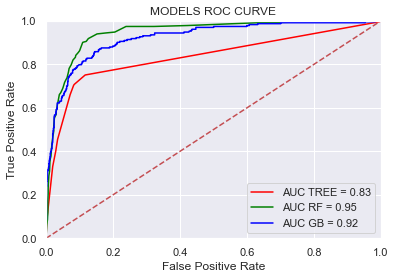

Root Mean Square Average for Defaulted Loan Loss
Decision Tree 4374.999394824516
Random Forest 2468.1956327670423
Gradiant Boosting 1951.1334193497357


In [115]:
#Wow! Gradiant boosting produces the smallest RMSE compared to the training and testing data sets for the random forest
#and decision tree models. All three models are in agreement that loan amount and debt to income ratio are the most 
#vital factors in predicting defaulted loan loss amount.

#Let's wrap things up by comparing the ROC curves and RSME of all three models.

plt.title('MODELS ROC CURVE')
plt.plot(fpr_tree, tpr_tree, 'b', label = 'AUC TREE = %0.2f' % auc_tree, color="red")
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC RF = %0.2f' % auc_RF, color="green")
plt.plot(fpr_GB, tpr_GB, 'b', label = 'AUC GB = %0.2f' % auc_GB, color="blue")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



print("Root Mean Square Average for Defaulted Loan Loss")
print("Decision Tree", RMSE_TREE)
print("Random Forest", RMSE_RF)
print("Gradiant Boosting", RMSE_GB)

In [116]:
#We can see that all three models are fairly accurate in predicting whether a loan will default. However, the gradiant
#boosting model is far and away the best at predicting defaulted loan loss amount. This would suggest that the gradiant
#boosting model would be the model one should utilize for this type of prediction illustrating why it often wins kaggle
#competitions.

#In terms of fairness with regards to fair lending laws and practices, things become a little less clear. The black box
#nature of random forests and gradiant boosting models can introduce unfair bias and discrimination when making lending 
#decisions. The algorithms themselves are not biased, but the individuals writing the code can be and can hardwire that
#bias into the system by declaring which variables the model should consider. For personal purposes, I would use
#gradiant boosting models. For professional purposes, let's stick to the right side of the law with our standard decision 
#tree.